In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn import preprocessing 
import numpy as np
import os

In [2]:
cwd = os.getcwd()
test_set = pd.DataFrame(pd.read_csv(os.path.join(cwd, 'datasets/test_data.csv')))
dataset = pd.DataFrame(pd.read_csv(os.path.join(cwd, 'datasets/train_data.csv')))

In [3]:
dataset.head()

,ID,parents,has_nurs,form,children,housing,finance,social,health,app_status
0,1,usual,less_proper,complete,3,critical,convenient,problematic,not_recom,0
1,2,pretentious,very_crit,completed,1,convenient,inconv,nonprob,not_recom,0
2,3,pretentious,proper,incomplete,1,less_conv,convenient,slightly_prob,priority,1
3,4,great_pret,improper,complete,1,convenient,convenient,nonprob,recommended,1
4,5,great_pret,less_proper,completed,1,convenient,convenient,slightly_prob,priority,1


In [4]:
dataset.shape

(10368, 10)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10368 entries, 0 to 10367
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          10368 non-null  int64 
 1   parents     10368 non-null  object
 2   has_nurs    10368 non-null  object
 3   form        10368 non-null  object
 4   children    10368 non-null  object
 5   housing     10368 non-null  object
 6   finance     10368 non-null  object
 7   social      10368 non-null  object
 8   health      10368 non-null  object
 9   app_status  10368 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 810.1+ KB


In [6]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        2592 non-null   int64 
 1   parents   2592 non-null   object
 2   has_nurs  2592 non-null   object
 3   form      2592 non-null   object
 4   children  2592 non-null   object
 5   housing   2592 non-null   object
 6   finance   2592 non-null   object
 7   social    2592 non-null   object
 8   health    2592 non-null   object
dtypes: int64(1), object(8)
memory usage: 182.4+ KB


In [7]:
dataset[dataset.isnull().any(axis=1)]    # any null records available?
del dataset['ID']
del test_set['ID']
del dataset['form']
del test_set['form']

### Label Encoding

In [8]:
label_encoder = preprocessing.LabelEncoder()

In [9]:
# Label Encoding for ordinal columns
def clean_ordinal(dataset):
    columns_ordinal = ['parents', 'has_nurs', 'children', 'housing', 'social', 'health', 'finance']

    for column in columns_ordinal:
        dataset[column] = label_encoder.fit_transform(dataset[column])
    return dataset

### One Hot Encoding

In [10]:
onehot_encoder = preprocessing.OneHotEncoder(drop='first')

In [11]:
# OneHotEncoding for nominal columns
def clean_nominal(dataset):
    columns_nominal = []

    cleaned_dataset = dataset

    for column in columns_nominal:
        X = onehot_encoder.fit_transform(dataset[column].values.reshape(-1, 1)).toarray()
        # create dataframe from encoded data
        dataset_onehot = pd.DataFrame(X, columns = [column + '_' + str(i) for i in range(X.shape[1])]) 
        # update dataset -> cleaned_dataset
        cleaned_dataset = pd.concat([dataset_onehot, cleaned_dataset], axis=1)
        # remove encoded column from dataset
        del cleaned_dataset[column]
    return cleaned_dataset

In [12]:
# Test set cleaning
test_set = clean_ordinal(test_set)
cleaned_test_set = clean_nominal(test_set)
cleaned_test_set.head()

,parents,has_nurs,children,housing,finance,social,health
0,2,3,0,0,0,0,2
1,2,3,0,0,1,0,1
2,2,3,0,0,1,1,1
3,2,3,0,2,0,1,2
4,2,3,0,2,0,1,1


In [14]:
cleaned_dataset = clean_nominal(clean_ordinal(dataset))
cleaned_dataset.head()

,parents,has_nurs,children,housing,finance,social,health,app_status
0,2,2,2,1,0,1,0,0
1,1,4,0,0,1,0,0,0
2,1,3,0,2,0,2,1,1
3,0,1,0,0,0,0,2,1
4,0,2,0,0,0,2,1,1


### Independant dependant var splitting

In [15]:
x = cleaned_dataset.iloc[:, 0:-1]
y = cleaned_dataset.iloc[:, -1]

### Normalizing

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 

x = scaler.fit_transform(x)

### Test train split

In [36]:
# splitting dataset to training and testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

### Classifier

In [37]:
x_train.shape

(7257, 7)

In [38]:
from keras.models import Sequential
from keras.layers import Dense

In [105]:
classifier = Sequential()

In [106]:
activation = 'tanh'

In [107]:
classifier.add(Dense(25,
                     input_shape=(7, ),
                     kernel_initializer='uniform',
                     activation=activation                       
                    )
              )

In [108]:
classifier.add(Dense(25,
                     kernel_initializer='uniform',
                     activation=activation                        
                    )
              )

In [109]:
classifier.add(Dense(5,
                     kernel_initializer='uniform',
                     activation='softmax'                        
                    )
              )

In [110]:
classifier.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']
                  )

In [111]:
classifier.fit(x_train, y_train, batch_size=10, epochs=100)

Epoch 1/100
726/726 [==============================] - 1s 806us/step - loss: 0.8836 - accuracy: 0.6446
Epoch 2/100
726/726 [==============================] - 0s 686us/step - loss: 0.6328 - accuracy: 0.6596
Epoch 3/100
726/726 [==============================] - 1s 767us/step - loss: 0.4365 - accuracy: 0.7691
Epoch 4/100
726/726 [==============================] - 1s 741us/step - loss: 0.4100 - accuracy: 0.7714
Epoch 5/100
726/726 [==============================] - 1s 723us/step - loss: 0.4049 - accuracy: 0.7739
Epoch 6/100
726/726 [==============================] - 1s 727us/step - loss: 0.3903 - accuracy: 0.7790
Epoch 7/100
726/726 [==============================] - 1s 701us/step - loss: 0.3832 - accuracy: 0.7832
Epoch 8/100
726/726 [==============================] - 1s 730us/step - loss: 0.3745 - accuracy: 0.7913
Epoch 9/100
726/726 [==============================] - 1s 714us/step - loss: 0.3720 - accuracy: 0.7977
Epoch 10/100
726/726 [==============================] - 1s 738us/step - l

726/726 [==============================] - 1s 895us/step - loss: 0.0632 - accuracy: 0.9692
Epoch 80/100
726/726 [==============================] - 1s 887us/step - loss: 0.0632 - accuracy: 0.9708
Epoch 81/100
726/726 [==============================] - 1s 688us/step - loss: 0.0621 - accuracy: 0.9730
Epoch 82/100
726/726 [==============================] - 1s 722us/step - loss: 0.0708 - accuracy: 0.9700
Epoch 83/100
726/726 [==============================] - 1s 821us/step - loss: 0.0636 - accuracy: 0.9704
Epoch 84/100
726/726 [==============================] - 1s 969us/step - loss: 0.0685 - accuracy: 0.9684
Epoch 85/100
726/726 [==============================] - 1s 854us/step - loss: 0.0659 - accuracy: 0.9724
Epoch 86/100
726/726 [==============================] - 1s 942us/step - loss: 0.0628 - accuracy: 0.9722
Epoch 87/100
726/726 [==============================] - 1s 801us/step - loss: 0.0685 - accuracy: 0.9687
Epoch 88/100
726/726 [==============================] - 1s 979us/step - loss:

In [114]:
# from sklearn import metrics
# y_pred = (classifier.predict(x_test) > 0.5)

# print('Accuracy', metrics.accuracy_score(y_test, y_pred))
# for tanh, sigmoid, binarycrossentropy -> 96.88%
loss, accuracy = classifier.evaluate(x_test,y_test)

98/98 [==============================] - 0s 443us/step - loss: 0.0696 - accuracy: 0.9704


In [115]:
print(accuracy*100)

97.04275131225586


### Confusion matrix

In [125]:
from sklearn.metrics import confusion_matrix

predict = classifier.predict(x_test)

predict_class = np.argmax(predict, axis=1)
predict_class = np.array(predict_class.tolist())
predict_class

array([1, 0, 0, ..., 0, 0, 1])

In [126]:
pd.crosstab(y_test, predict_class, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1947,34,1981
1,58,1072,1130
All,2005,1106,3111


### Classification report

In [128]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_class))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1981
           1       0.97      0.95      0.96      1130

    accuracy                           0.97      3111
   macro avg       0.97      0.97      0.97      3111
weighted avg       0.97      0.97      0.97      3111



### ROC-AUC

In [132]:
y_pred_proba = classifier.predict_proba(x_test)[:,1]
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

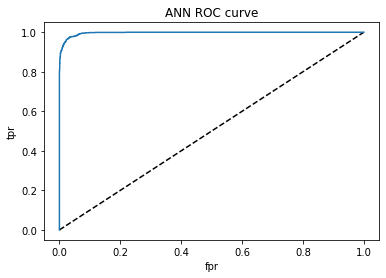

In [134]:
import matplotlib.pyplot as plt

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ANN ROC curve')
plt.show()

In [135]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.9969462102361817